# Installs and Imports


In [87]:
%%capture
# --- Install PyTorch Geometric and its dependencies (CPU version, Torch 2.0) ---
!pip install torch-scatter torch-sparse torch-geometric \
    -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

# --- Install geospatial and plotting packages ---
!pip install geopandas shapely matplotlib

# --- Progress bar for loops ---
!pip install tqdm

# --- Optuna for hyperparameter tuning ---
!pip install Optuna

In [88]:
%%capture
# --- Colab and I/O ---
from google.colab import drive
from tqdm.notebook import tqdm  # Colab-friendly progress bar
from tqdm import trange
from IPython.display import display
import os
import warnings
import pickle
import json
import warnings

# --- Geo and plotting libraries ---
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# --- Core scientific libraries ---
import numpy as np
import networkx as nx
import pandas as pd
import math
import optuna


# --- PyTorch and PyG (Graph Neural Networks) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from itertools import product

# --- Scikit-learn ---
from scipy.stats import pearsonr, ConstantInputWarning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

# Functions

In [89]:
def load_gdf(filepath):
    gdf = gpd.read_file(filepath)
    print(f"✅ Loaded {len(gdf)} datapoints from {filepath}")
    gdf = gdf.reset_index(drop=True)
    return gdf

def load_graph(path):
    with open(path, 'rb') as f:
        graph = pickle.load(f)
    print(f"✅ Loaded graph from {path} with {len(graph.nodes)} nodes and {len(graph.edges)} edges")
    return graph

def check_graph_gdf_alignment(graph, gdf, label=""):
    gdf_indices = set(gdf.index)
    graph_nodes = set(graph.nodes)

    if not graph_nodes.issubset(gdf_indices):
        raise ValueError(f"⚠️ {label}: Graph nodes not a subset of GeoDataFrame indices!")

    if len(graph.nodes) != len(gdf):
        print(f"⚠️ {label}: Graph has {len(graph.nodes)} nodes, but gdf has {len(gdf)} rows.")
    else:
        print(f"✅ {label}: Graph and GeoDataFrame are properly aligned.")

def get_coarse_node_indices(current_graph, baseline_graph):
    """
    Identify coarse node indices by comparing the current coarsened graph to the baseline graph.

    Parameters:
        current_graph (networkx.Graph): Coarsened graph (e.g., at level 2, 4, etc.).
        baseline_graph (networkx.Graph): Original fine-resolution graph.

    Returns:
        list: Node indices present in current_graph but not in baseline_graph (i.e., coarse nodes).
    """
    baseline_nodes = set(baseline_graph.nodes)
    current_nodes = set(current_graph.nodes)

    coarse_indices = list(current_nodes - baseline_nodes)
    print(f"Found {len(coarse_indices)} coarse nodes")
    return coarse_indices

def describe_graph(G, show_basic=True, show_degree=True, show_diameter=False):
    print("📊 Graph Summary")

    if show_basic:
        print(f"- Nodes: {G.number_of_nodes()}")
        print(f"- Edges: {G.number_of_edges()}")

    if show_degree:
        degrees = [d for _, d in G.degree()]
        avg_degree = sum(degrees) / len(degrees) if degrees else 0
        print(f"- Average degree: {avg_degree:.2f}")

    if show_diameter:
        if nx.is_connected(G):
            print(f"- Diameter: {nx.diameter(G)}")
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            print(f"- Diameter (largest connected component): {nx.diameter(subgraph)}")

def build_edge_index(graph, node_offset=0):
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    if node_offset > 0:
        edge_index += node_offset
    return torch.cat([edge_index, edge_index[[1, 0]]], dim=1)

def setup_data_object(gdf, feature_cols, target_col, G):
    # Relabel nodes to match gdf indices
    G = nx.relabel_nodes(G, {old_idx: new_idx for new_idx, old_idx in enumerate(gdf.index)})

    # Edge index (undirected)
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)

    # Node features and target
    x = torch.tensor(gdf[feature_cols].values, dtype=torch.float)
    y = torch.tensor(gdf[target_col].values, dtype=torch.float).view(-1, 1)

    data = Data(x=x, edge_index=edge_index, y=y)
    print(data)
    print(f"✅ Node features shape: {data.x.shape}")
    print(f"✅ Edge index shape: {data.edge_index.shape}")
    print(f"✅ Target shape: {data.y.shape}")
    return data, G

def predict_full_dataset(model, data, gdf, model_name="GCN"):
    """
    Predict on the full dataset and attach predictions + errors to GeoDataFrame.

    Parameters:
        model (nn.Module): Trained GNN model.
        data (PyG Data): Graph data object with .x, .y, .edge_index.
        gdf (GeoDataFrame): GeoDataFrame aligned with node indices.
        model_name (str): Used to name prediction/error columns.

    Returns:
        GeoDataFrame: Updated GeoDataFrame with predictions and errors.
    """
    if gdf is None:
        raise ValueError("❌ A valid GeoDataFrame must be provided to attach predictions.")

    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        preds = model(data.x.to(device), data.edge_index.to(device)).cpu().numpy().flatten()

    model_key = model_name.lower()
    gdf = gdf.copy()
    gdf["NO2_actual"] = data.y.cpu().numpy().flatten()
    gdf[f"NO2_pred_{model_key}"] = preds
    gdf[f"NO2_error_{model_key}"] = gdf[f"NO2_pred_{model_key}"] - gdf["NO2_actual"]

    print(f"✅ Attached predictions and errors to gdf for model: {model_name}")
    return gdf


def run_external_validation(gdf, palmes_gdf, model_name="GCN", search_radius=50):
    """
    Use prediction column in gdf to match Palmes tubes and compute external validation metrics.

    Parameters:
        gdf (GeoDataFrame): Must contain predictions (e.g., 'NO2_pred_gcn').
        palmes_gdf (GeoDataFrame): Contains Palmes tube locations and ground truth.
        model_name (str): Used for naming output columns.
        search_radius (float): Search radius in meters to match tubes to nearby segments.

    Returns:
        palmes_gdf (GeoDataFrame): Updated with prediction and error columns.
        metrics (dict): External validation metrics (rmse, mae, pearson_r2).
    """
    model_key = model_name.lower()
    pred_col = f"pred_mean_{model_key}"
    error_col = f"error_{model_key}"
    gdf_pred_col = f"NO2_pred_{model_key}"

    if gdf_pred_col not in gdf.columns:
        raise ValueError(f"Column '{gdf_pred_col}' not found in gdf. Make sure predictions are attached.")

    sindex = gdf.sindex

    mean_preds, actuals = [], []

    for _, row in palmes_gdf.iterrows():
        pt = row.geometry
        if pt is None or pt.is_empty:
            mean_preds.append(np.nan)
            actuals.append(np.nan)
            continue

        candidate_idxs = list(sindex.intersection(pt.buffer(search_radius).bounds))
        if candidate_idxs:
            geom_cand = gdf.loc[candidate_idxs, "geometry"]
            dists = geom_cand.distance(pt).values
            nearby = [candidate_idxs[i] for i, d in enumerate(dists) if d <= search_radius]
        else:
            nearby = []

        if not nearby:
            nearest_idx = gdf.geometry.distance(pt).idxmin()
            nearby = [nearest_idx]

        mean_pred = gdf.loc[nearby, gdf_pred_col].mean()
        mean_preds.append(mean_pred)
        actuals.append(row["mean_annual_palmes_no2"])

    # Attach predictions and errors to palmes_gdf
    palmes_gdf = palmes_gdf.copy()
    palmes_gdf[pred_col] = mean_preds
    palmes_gdf[error_col] = palmes_gdf[pred_col] - palmes_gdf["mean_annual_palmes_no2"]

    valid_mask = ~np.isnan(mean_preds) & ~np.isnan(actuals)
    y_true = np.array(actuals)[valid_mask]
    y_pred = np.array(mean_preds)[valid_mask]

    try:
        pearson_r, _ = pearsonr(y_true, y_pred)
        pearson_r2 = round(float(pearson_r) ** 2, 3)
    except Exception:
        pearson_r2 = None

    metrics = {
        "rmse": round(np.sqrt(mean_squared_error(y_true, y_pred)), 3),
        "mae": round(mean_absolute_error(y_true, y_pred), 3),
        "pearson_r2": pearson_r2
    }

    return palmes_gdf, metrics

def plot_density_comparison(gdf, palmes_gdf, model_name="GCN"):
    """
    Plots KDE curves to compare model predictions and measured NO₂, using consistent color coding.
    """
    pred_all_col = f"NO2_pred_{model_name.lower()}"
    pred_mean_col = f"pred_mean_{model_name.lower()}"
    actual_graph_col = "NO2_actual"
    actual_palmes_col = "mean_annual_palmes_no2"

    # Define consistent color palette
    colors = {
        "graph": "#1f77b4",   # blue
        "palmes": "#d62728",  # red
    }

    plt.figure(figsize=(10, 5))

    # Graph data (gdf)
    sns.kdeplot(gdf[actual_graph_col], label='NO₂ in Graph (Data Only)',
                linewidth=2, linestyle='--', color=colors["graph"])
    sns.kdeplot(gdf[pred_all_col], label='Model Predictions (All Segments)',
                linewidth=2, linestyle='-', color=colors["graph"])

    # Palmes data (point-based)
    sns.kdeplot(palmes_gdf[actual_palmes_col], label='Palmes Tube Measurements',
                linewidth=2, linestyle='--', color=colors["palmes"])
    sns.kdeplot(palmes_gdf[pred_mean_col], label='Model Predictions (Palmes Average)',
                linewidth=2, linestyle='-', color=colors["palmes"])

    plt.xlabel('NO₂ concentration (µg/m³)')
    plt.ylabel('Density')
    plt.title(f'Density Comparison: {model_name} Predictions vs Ground Truth')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_segment_predictions(gdf, model_name="GCN"):
    """
    Plots side-by-side maps of actual NO₂, predicted NO₂, and prediction error.

    Parameters:
        gdf (GeoDataFrame): Contains road segments and prediction columns.
        model_name (str): Used to locate model-specific columns.
    """
    pred_col = f"NO2_pred_{model_name.lower()}"
    error_col = f"NO2_error_{model_name.lower()}"
    actual_col = "NO2_actual"

    # Shared limits for consistent color scaling
    vmin = min(gdf[actual_col].min(), gdf[pred_col].min())
    vmax = max(gdf[actual_col].max(), gdf[pred_col].max())

    # Symmetric colormap around zero for error
    max_abs_error = gdf[error_col].abs().max()
    error_norm = mcolors.TwoSlopeNorm(vmin=-max_abs_error, vcenter=0, vmax=max_abs_error)

    fig, axs = plt.subplots(1, 3, figsize=(22, 8))
    cmap_main = 'YlOrRd'  # For actual and predicted
    cmap_error = 'bwr'    # For error (diverging)

    # Actual NO₂
    gdf.plot(
        column=actual_col,
        cmap=cmap_main,
        linewidth=1,
        ax=axs[0],
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    axs[0].set_title('Actual NO₂ Levels')
    axs[0].set_axis_off()

    # Predicted NO₂
    gdf.plot(
        column=pred_col,
        cmap=cmap_main,
        linewidth=1,
        ax=axs[1],
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    axs[1].set_title(f'Predicted NO₂ Levels ({model_name})')
    axs[1].set_axis_off()

    # Prediction Error
    gdf.plot(
        column=error_col,
        cmap=cmap_error,
        linewidth=1,
        ax=axs[2],
        legend=True,
        norm=error_norm
    )
    axs[2].set_title('Prediction Error (Pred - Actual)')
    axs[2].set_axis_off()

    plt.tight_layout()
    plt.show()

def create_masks(data, split_path=None, test_size=0.15, random_state=42,
                 outlier_indices=None, exclude_indices=None, verbose=True):
    # Identify labeled and unlabeled nodes
    data.labeled_mask = ~torch.isnan(data.y.view(-1))
    data.unlabeled_mask = ~data.labeled_mask

    labeled_indices = data.labeled_mask.nonzero(as_tuple=True)[0].cpu().numpy()
    unlabeled_indices = data.unlabeled_mask.nonzero(as_tuple=True)[0].cpu().numpy()

    num_total = data.num_nodes
    num_labeled = len(labeled_indices)
    num_unlabeled = len(unlabeled_indices)

    # Split labeled nodes into trainval and test
    trainval_indices, test_indices = train_test_split(
        labeled_indices, test_size=test_size, random_state=random_state
    )

    num_test = len(test_indices)
    num_trainval_before = len(trainval_indices)

    # Remove outliers from trainval set only
    if outlier_indices is not None:
        outlier_indices = set(outlier_indices)
        trainval_indices = [i for i in trainval_indices if i not in outlier_indices]
        num_removed = num_trainval_before - len(trainval_indices)
    else:
        num_removed = 0

    # Remove excluded nodes (e.g., coarse nodes) from BOTH trainval and test sets
    if exclude_indices is not None:
        exclude_indices = set(exclude_indices)
        trainval_indices = [i for i in trainval_indices if i not in exclude_indices]
        test_indices = [i for i in test_indices if i not in exclude_indices]

    num_trainval_after = len(trainval_indices)
    num_test_after = len(test_indices)

    # Create and store test mask
    data.test_mask = torch.zeros(num_total, dtype=torch.bool)
    data.test_mask[test_indices] = True

    # Optional printing
    if verbose:
        print("🧾 === Data Split Summary ===")
        print(f"🔢 Total nodes in graph: {num_total}")
        print(f"🟢 Labeled nodes (non-NaN target): {num_labeled} ({100 * num_labeled / num_total:.1f}% of total)")
        print(f"⚪ Unlabeled nodes (NaN target): {num_unlabeled} ({100 * num_unlabeled / num_total:.1f}% of total)\n")
        print(f"📌 Test set: {num_test_after} nodes ({100 * num_test_after / num_labeled:.1f}% of labeled nodes)")
        print(f"🧪 Train+Val set before outlier removal: {num_trainval_before} nodes "
              f"({100 * num_trainval_before / num_labeled:.1f}% of labeled nodes)")
        if num_removed > 0:
            print(f"❌ Outliers removed from Train+Val set: {num_removed} nodes")
        if exclude_indices is not None:
            print(f"🚫 Excluded from both sets (e.g., coarse nodes): {len(exclude_indices)} nodes")
        print(f"✅ Final Train+Val set after exclusion: {num_trainval_after} nodes "
              f"({100 * num_trainval_after / num_labeled:.1f}% of labeled nodes)")
        print("🚫 Unlabeled nodes are excluded from both training and test sets.")

    # Save test indices if requested
    if split_path:
        np.save(split_path, test_indices)

    return trainval_indices

def get_node_mask(data, exclude_indices=None, verbose=True):
    """
    Returns a boolean mask of labeled nodes, optionally excluding specific node indices.

    Includes:
        - All labeled nodes (non-NaN targets)
        - Optionally excludes nodes given in `exclude_indices`

    Args:
        data (torch_geometric.data.Data): PyG data object with .y
        exclude_indices (list or set, optional): Node indices to exclude (e.g., outliers, coarse nodes)
        verbose (bool): Whether to print a summary

    Returns:
        node_mask (torch.BoolTensor): Mask of shape [num_nodes]
    """
    num_nodes = data.num_nodes

    # Start with all labeled nodes
    node_mask = ~torch.isnan(data.y.view(-1))

    # Exclude specific nodes if provided
    if exclude_indices is not None:
        node_mask[exclude_indices] = False

    if verbose:
        total = num_nodes
        labeled = (~torch.isnan(data.y)).sum().item()
        masked = node_mask.sum().item()
        print(f"🧩 Node Mask Summary:")
        print(f"✔️ Total nodes: {total}")
        print(f"✔️ Labeled nodes: {labeled} ({100 * labeled / total:.1f}%)")
        print(f"✅ Nodes used after exclusion: {masked} ({100 * masked / total:.1f}%)")
        if exclude_indices:
            print(f"🚫 Nodes excluded: {len(exclude_indices)}")

    return node_mask


def run_internal_validation(data, model_class, feature_cols, config, verbose=True):
    """
    Trains and evaluates a model using data.train_mask and data.val_mask.

    Assumes:
        - data.train_mask is a boolean mask for training nodes
        - data.val_mask is a boolean mask for validation nodes

    Args:
        data (PyG Data): Graph with .x, .y, .edge_index, and pre-set masks
        model_class (nn.Module): The GNN model class
        feature_cols (list): List of input features (not used explicitly here)
        config (dict): Hyperparameters, including:
            - hidden_channels
            - num_layers
            - dropout
            - activation
            - heads (optional)
            - lr
            - epochs
            - early_stopping_patience (optional)
        verbose (bool): Whether to print progress

    Returns:
        model (nn.Module): Trained model
        dict: Evaluation metrics (MSE, RMSE, MAE, R², epochs_used)
    """

    model = model_class(
        in_channels=len(feature_cols),
        hidden_channels=config['hidden_channels'],
        out_channels=1,
        dropout=config['dropout'],
        num_layers=config['num_layers'],
        activation=config['activation'],
        heads=config.get('heads', 1)
    ).to(data.x.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    loss_fn = torch.nn.MSELoss()

    best_loss = float("inf")
    patience = config.get("early_stopping_patience", None)
    patience_counter = 0
    final_epoch = config.get("epochs", 2000)

    for epoch in range(config.get("epochs", 2000)):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        if patience is not None:
            if current_loss < best_loss - 1e-5:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    final_epoch = epoch + 1
                    break

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(data.x, data.edge_index).cpu().numpy().flatten()

        if not hasattr(data, 'val_mask') or data.val_mask.sum() == 0:
            raise ValueError("No valid val_mask found on data object for evaluation.")

        y_true = data.y[data.val_mask].cpu().numpy().flatten()
        y_pred = preds[data.val_mask.cpu().numpy()].flatten()

    if np.isnan(y_true).any() or np.isnan(y_pred).any():
        raise ValueError("❌ NaNs found in y_true or y_pred during evaluation.")

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConstantInputWarning)
        pearson_r, _ = pearsonr(y_true, y_pred)
        if any(issubclass(wc.category, ConstantInputWarning) for wc in w):
            print("⚠️ Constant prediction detected")
        pearson_r2 = round(float(pearson_r) ** 2, 3)

    if verbose:
        print("✅ Internal Validation")
        print(f"  RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {pearson_r2:.2f}")

    return model, {
        "mse": round(mse, 5),
        "rmse": round(rmse, 3),
        "mae": round(mae, 3),
        "pearson_r2": pearson_r2,
        "epochs_used": final_epoch
    }


def run_optuna_tuning(
    model_class,
    model_name,
    data,
    feature_cols,
    param_grid,
    used_mask,  # ✅ Pass a boolean mask: True = use node in tuning
    n_trials=100,
    n_startup_trials=40,
    n_folds=3,
    epoch_per_fold=20,
    verbose=True
):
    """
    Runs Optuna hyperparameter tuning using K-Fold CV on the subset of nodes defined by `used_mask`.

    Args:
        model_class (nn.Module): The GNN model class (GCN, GAT, etc.)
        model_name (str): Model name for logging and config use.
        data (PyG Data): Graph data object with .x, .y, and .edge_index.
        feature_cols (list): Feature column names (for internal val).
        param_grid (dict): Search space for hyperparameters.
        used_mask (Tensor): Boolean mask of shape [num_nodes], specifying which nodes to include in tuning.
        n_trials (int): Number of Optuna trials.
        n_startup_trials (int): Startup trials before pruning.
        n_folds (int): Number of CV folds.
        epoch_per_fold (int): Epochs per trial.
        verbose (bool): Print progress if True.

    Returns:
        dict: Best configuration found by Optuna.
    """

    # ✅ Extract indices to use in tuning
    used_indices = torch.where(used_mask)[0].cpu().numpy()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_splits = list(kf.split(used_indices))

    def objective(trial):
        # 🔁 Sample hyperparameters
        hidden_channels = trial.suggest_categorical("hidden_channels", param_grid["hidden_channels"])
        num_layers = trial.suggest_categorical("num_layers", param_grid["num_layers"])
        lr = trial.suggest_categorical("lr", param_grid["lr_range"])
        dropout = trial.suggest_float("dropout", *param_grid["dropout_range"], step=param_grid["dropout_step"])
        activation = trial.suggest_categorical("activation", param_grid["activation_functions"])
        heads = trial.suggest_categorical("heads", param_grid["heads"]) if model_name.lower() == "gat" else None

        config = {
            "hidden_channels": hidden_channels,
            "num_layers": num_layers,
            "lr": lr,
            "dropout": dropout,
            "activation": activation,
            "epochs": epoch_per_fold,
            "early_stopping_patience": None  # for now no early stopping inside Optuna trials
        }
        if heads is not None:
            config["heads"] = heads

        mse_scores = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv_splits):
            train_nodes = used_indices[train_idx]
            val_nodes = used_indices[val_idx]

            # ✅ Create masks for this fold
            train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            train_mask[train_nodes] = True
            val_mask[val_nodes] = True

            # Assign to data object (used by your model)
            data.train_mask = train_mask.to(data.x.device)
            data.val_mask = val_mask.to(data.x.device)

            # Reuse your internal validation function
            _, metrics = run_internal_validation(
                data=data,
                model_class=model_class,
                feature_cols=feature_cols,
                config=config,
                verbose=False
            )

            mse_scores.append(metrics["mse"])
            trial.report(np.mean(mse_scores), step=fold_idx)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return np.mean(mse_scores)

    # Create and run study
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(n_startup_trials=n_startup_trials),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=n_startup_trials),
        study_name=f"Optuna_{model_name}"
    )

    if verbose:
        print(f"🚀 Starting Optuna tuning ({n_trials} trials, {n_folds}-fold CV)...")

    study.optimize(objective, n_trials=n_trials, show_progress_bar=verbose)

    # Extract best config
    best_config = study.best_trial.params
    best_config["epochs"] = epoch_per_fold
    best_config["early_stopping_patience"] = None
    if model_name.lower() != "gat":
        best_config.pop("heads", None)

    if verbose:
        print(f"✅ Best config: {best_config}")
        print(f"📉 Best MSE: {study.best_value:.4f}")

    return best_config

def run_internal_cv(
    model_class,
    model_name,
    data,
    feature_cols,
    config,
    internal_validation_mask,
    outlier_indices=None,
    n_folds=10,
    max_epochs=2000,
    early_stopping_patience=50,
    verbose=True
):
    """
    Runs k-fold cross-validation using a fixed config to report internal validation metrics.
    """

    all_mse, all_rmse, all_mae, all_r2, all_epochs = [], [], [], [], []

    indices = torch.where(internal_validation_mask)[0].cpu().numpy()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
        train_nodes = indices[train_idx]
        val_nodes = indices[val_idx]

        if outlier_indices is not None:
            train_nodes = [i for i in train_nodes if i not in outlier_indices]

        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        train_mask[train_nodes] = True
        val_mask[val_nodes] = True

        data.train_mask = train_mask.to(data.x.device)
        data.val_mask = val_mask.to(data.x.device)

        config_fold = config.copy()
        config_fold["epochs"] = max_epochs
        config_fold["early_stopping_patience"] = early_stopping_patience

        _, metrics = run_internal_validation(
            data=data,
            model_class=model_class,
            feature_cols=feature_cols,
            config=config_fold,
            verbose=False
        )

        all_mse.append(metrics["mse"])
        all_rmse.append(metrics["rmse"])
        all_mae.append(metrics["mae"])
        all_r2.append(metrics["pearson_r2"])
        all_epochs.append(metrics["epochs_used"])

        if verbose:
            print(f"📊 Fold {fold_idx+1}/{n_folds} - MSE: {metrics['mse']:.4f}, "
                  f"R²: {metrics['pearson_r2']:.3f}, Epochs: {metrics['epochs_used']}")

    summary = {
        "all_runs": {
            "mse": all_mse,
            "rmse": all_rmse,
            "mae": all_mae,
            "pearson_r2": all_r2,
            "epochs": all_epochs
        },
        "mean_rmse": np.mean(all_rmse),
        "std_rmse": np.std(all_rmse),
        "mean_mae": np.mean(all_mae),
        "std_mae": np.std(all_mae),
        "mean_pearson_r2": np.mean(all_r2),
        "std_pearson_r2": np.std(all_r2),
        "mean_epochs": np.mean(all_epochs),
        "std_epochs": np.std(all_epochs)
    }

    if verbose:
        print("\n📈 Cross-Validation Summary:")
        print(f"  RMSE   → Mean: {summary['mean_rmse']:.3f}, Std: {summary['std_rmse']:.3f}")
        print(f"  MAE    → Mean: {summary['mean_mae']:.3f}, Std: {summary['std_mae']:.3f}")
        print(f"  R²     → Mean: {summary['mean_pearson_r2']:.3f}, Std: {summary['std_pearson_r2']:.3f}")
        print(f"  Epochs → Mean: {summary['mean_epochs']:.1f}, Std: {summary['std_epochs']:.1f}")

    return summary

def train_final_model(
    model_class,
    model_name: str,
    data,
    feature_cols,
    config,
    final_train_mask,
    max_epochs=2000,
    early_stopping_patience=50,
    verbose=True
):
    """
    Trains the final GNN model using the full training mask.

    Args:
        model_class: GNN model class to instantiate (e.g., GCN, GAT).
        model_name (str): Label for logging purposes.
        data (torch_geometric.data.Data): PyG graph data object.
        feature_cols (list): List of input feature names.
        config (dict): Best hyperparameter config from Optuna.
        final_train_mask (Tensor): Boolean mask indicating training nodes.
        max_epochs (int): Max training epochs.
        early_stopping_patience (int): Early stopping patience.
        verbose (bool): Whether to print epoch summary.

    Returns:
        model: Trained PyTorch model
    """
    model = model_class(
        in_channels=len(feature_cols),
        hidden_channels=config["hidden_channels"],
        out_channels=1,
        dropout=config["dropout"],
        num_layers=config["num_layers"],
        activation=config["activation"],
        heads=config.get("heads", 1)
    ).to(data.x.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    loss_fn = torch.nn.MSELoss()

    best_loss = float("inf")
    patience_counter = 0
    final_epoch = max_epochs

    for epoch in trange(max_epochs, desc=f"🧠 Training {model_name}", leave=True):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[final_train_mask], data.y[final_train_mask])
        loss.backward()
        optimizer.step()

        if early_stopping_patience is not None:
            if loss.item() < best_loss - 1e-5:
                best_loss = loss.item()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    final_epoch = epoch + 1
                    break

    if verbose:
        print(f"✅ Final model trained for {final_epoch} epochs")

    return model

def export_results(
    gdf,
    palmes_gdf,
    export_model_name,
    config,
    internal_metrics,
    external_metrics,
    output_dir="./results"
):
    """
    Save all outputs: predictions, metrics, and config to disk, with warning if files exist.

    Parameters:
        gdf (GeoDataFrame): GeoDataFrame with prediction and error columns.
        palmes_gdf (GeoDataFrame): Tubes matched with predictions.
        export_model_name (str): Model name (e.g., "GCN").
        config (dict): Best config used for final model.
        internal_metrics (dict): Internal CV metrics.
        external_metrics (dict): External validation metrics.
        output_dir (str): Output directory for saving files.
    """
    os.makedirs(output_dir, exist_ok=True)
    model_key = export_model_name.lower()

    # Prepare file paths
    files_to_save = {
        "predictions": os.path.join(output_dir, f"{model_key}_predictions.geojson"),
        "palmes_matched": os.path.join(output_dir, f"{model_key}_palmes_matched.geojson"),
        "config": os.path.join(output_dir, f"{model_key}_config.json"),
        "internal_metrics": os.path.join(output_dir, f"{model_key}_internal_metrics.json"),
        "external_metrics": os.path.join(output_dir, f"{model_key}_external_metrics.json"),
    }

    # Check if any files exist
    existing = [name for name, path in files_to_save.items() if os.path.exists(path)]
    if existing:
        print("⚠️ The following files already exist and will be overwritten:")
        for name in existing:
            print(f" - {files_to_save[name]}")
        response = input("❓ Do you want to proceed and overwrite them? (y/n): ").strip().lower()
        if response != 'y':
            print("❌ Export cancelled.")
            return

    # Save GeoDataFrames
    gdf.to_file(files_to_save["predictions"], driver="GeoJSON")
    palmes_gdf.to_file(files_to_save["palmes_matched"], driver="GeoJSON")

    # Save metrics and config
    with open(files_to_save["config"], "w") as f:
        json.dump(config, f, indent=2)

    with open(files_to_save["internal_metrics"], "w") as f:
        json.dump(internal_metrics, f, indent=2)

    with open(files_to_save["external_metrics"], "w") as f:
        json.dump(external_metrics, f, indent=2)

    print(f"✅ Results successfully exported to: {output_dir}")

# Loading the Data

In [90]:
# Mounting drive for permanent data access
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [91]:
# coarsening_level = 4
# gdf = load_gdf(f'/content/drive/MyDrive/gnn_project/processed_data/hierarchical_{coarsening_level}_gdf.geojson')
# G = load_graph(f'/content/drive/MyDrive/gnn_project/processed_data/hierarchical_{coarsening_level}_graph.pkl')
# check_graph_gdf_alignment(G, gdf, label="Hierarchical Graph")

In [92]:
gdf = load_gdf('/content/drive/MyDrive/Universiteit Utrecht/Thesis/outputs/data/road_network_features.geojson')
G = load_graph(f'/content/drive/MyDrive/Universiteit Utrecht/Thesis/outputs/data/G_gat_augmented.gpickle')

✅ Loaded 48595 datapoints from /content/drive/MyDrive/Universiteit Utrecht/Thesis/outputs/data/road_network_features.geojson
✅ Loaded graph from /content/drive/MyDrive/Universiteit Utrecht/Thesis/outputs/data/G_gat_augmented.gpickle with 48595 nodes and 58498 edges


In [93]:
# baseline_gdf = load_gdf('/content/drive/MyDrive/gnn_project/processed_data/road_network_lufeature.geojson')
# baseline_graph = load_graph(f'/content/drive/MyDrive/gnn_project/processed_data/baseline_graph.pkl')

In [94]:
# Check basic stats for each input feature
gdf.describe()

,ROAD_FID,NO2d,X,POINT_X,POINT_Y,AGRI_100,INDUS_100,NATUR_100,PORT_100,RES_100,...,HLOA_1000,MRDL_1000,TMLOA_1000,HMLOA_1000,TRAFNEAR,HTRAFNEAR,DINVNEAR,TRAFMAJOR,HTRAFMAJOR,DINVMAJOR
count,47963.000000,46664.000000,48595.000000,48595.000000,48595.000000,48595.000000,48595.000000,48595.000000,48595.000000,48595.000000,...,4.859500e+04,48595.000000,4.859500e+04,4.859500e+04,48595.000000,48595.000000,4.859500e+04,48595.000000,48595.000000,4.859500e+04
mean,28092.617017,27.783838,28789.906451,120999.975373,486363.458192,1062.968861,2003.214010,18.178401,2543.887506,21953.674358,...,1.960465e+07,14063.361122,2.736002e+08,1.539008e+07,8841.323819,550.365449,6.173251e+07,14770.411750,769.288692,4.798503e+06
std,16314.706462,12.363414,16770.229795,4092.479882,3376.181549,5159.037740,7193.665822,498.838908,8190.863711,13658.084962,...,1.800178e+07,5256.123473,2.055885e+08,1.731426e+07,19549.907952,1784.148761,1.757667e+09,21999.058023,2067.957426,4.680950e+08
min,1.000000,10.000000,16.000000,110183.695400,476797.311900,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.582000e+03,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,13958.500000,19.000000,14244.500000,117994.767800,484384.697000,0.000000,0.000000,0.000000,0.000000,1314.920413,...,5.296169e+06,10531.575693,1.227710e+08,2.123927e+06,263.000000,3.000000,2.571897e-01,4224.000000,42.000000,7.180103e-03
50%,28011.000000,25.000000,28626.000000,121099.508100,486331.725200,0.000000,0.000000,0.000000,0.000000,31415.509573,...,1.105204e+07,14225.008392,2.039170e+08,4.773959e+06,1546.000000,34.000000,1.231082e+00,8963.000000,111.000000,1.762142e-02
75%,42107.500000,33.000000,43155.500000,124209.890300,488772.206200,0.000000,0.000000,0.000000,0.000000,31415.509574,...,3.426972e+07,17759.499732,4.211714e+08,3.024292e+07,9108.000000,217.000000,3.987059e+01,14400.000000,376.000000,3.285653e-01
max,56600.000000,95.000000,58377.000000,133290.907900,493830.854300,31415.509713,31415.509574,28563.991284,31415.509574,31415.509574,...,7.545471e+07,28087.605690,9.045850e+08,7.455013e+07,167486.000000,18371.000000,6.871948e+10,171930.000000,15268.000000,6.871948e+10


In [95]:
describe_graph(G, show_basic=True, show_degree=True, show_diameter=False)

📊 Graph Summary
- Nodes: 48595
- Edges: 58498
- Average degree: 2.41


In [96]:
# 1. Load the Palmes measurement points using the helper function
palmes_gdf = load_gdf('/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_palmes_25m.geojson')

# 2. Make sure both GeoDataFrames share the same CRS
palmes_gdf = palmes_gdf.to_crs(gdf.crs)  # Assumes `gdf` already loaded before

# 3. Build a spatial index over your road‐node GeoDataFrame
sindex = gdf.sindex

# 4. For each measurement point, find all nodes within `search_radius` (m)
search_radius = 50  # adjust to taste

✅ Loaded 83 datapoints from /content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_palmes_25m.geojson


# Feature Selection and Scaling (only for unscaled data)

In [97]:
# Select features and target
feature_cols = ['AGRI_100', 'INDUS_100', 'NATUR_100', 'PORT_100', 'RES_100', 'TRANS_100', 'URBG_100', 'WATER_100', 'AGRI_300', 'INDUS_300', 'NATUR_300', 'PORT_300', 'RES_300', 'TRANS_300', 'URBG_300', 'WATER_300', 'AGRI_500', 'INDUS_500', 'NATUR_500', 'PORT_500', 'RES_500', 'TRANS_500', 'URBG_500', 'WATER_500', 'AGRI_1000', 'INDUS_1000', 'NATUR_1000', 'PORT_1000', 'RES_1000', 'TRANS_1000', 'URBG_1000', 'WATER_1000', 'AGRI_5000', 'AIR_5000', 'INDUS_5000', 'NATUR_5000', 'PORT_5000', 'RES_5000', 'TRANS_5000', 'URBG_5000', 'WATER_5000', 'POP_100', 'POP_300', 'POP_500', 'POP_1000', 'POP_5000', 'EEA_100', 'EEA_300', 'EEA_500', 'EEA_1000', 'EEA_5000', 'HHOLD_100', 'HHOLD_300', 'HHOLD_500', 'HHOLD_1000', 'RDL_25', 'TLOA_25', 'HLOA_25', 'MRDL_25', 'TMLOA_25', 'HMLOA_25', 'RDL_50', 'TLOA_50', 'HLOA_50', 'MRDL_50', 'TMLOA_50', 'HMLOA_50', 'RDL_100', 'TLOA_100', 'HLOA_100', 'MRDL_100', 'TMLOA_100', 'HMLOA_100', 'RDL_300', 'TLOA_300', 'HLOA_300', 'MRDL_300', 'TMLOA_300', 'HMLOA_300', 'RDL_500', 'TLOA_500', 'HLOA_500', 'MRDL_500', 'TMLOA_500', 'HMLOA_500', 'RDL_1000', 'TLOA_1000', 'HLOA_1000', 'MRDL_1000', 'TMLOA_1000', 'HMLOA_1000', 'TRAFNEAR', 'HTRAFNEAR', 'DINVNEAR', 'TRAFMAJOR', 'HTRAFMAJOR', 'DINVMAJOR']
target_col = 'NO2d'

In [98]:
scaler = StandardScaler()
gdf[feature_cols] = scaler.fit_transform(gdf[feature_cols])

# Check basic stats for each input feature
gdf[feature_cols].describe()

,AGRI_100,INDUS_100,NATUR_100,PORT_100,RES_100,TRANS_100,URBG_100,WATER_100,AGRI_300,INDUS_300,...,HLOA_1000,MRDL_1000,TMLOA_1000,HMLOA_1000,TRAFNEAR,HTRAFNEAR,DINVNEAR,TRAFMAJOR,HTRAFMAJOR,DINVMAJOR
count,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,...,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04,4.859500e+04
mean,-2.807371e-17,-7.018428e-18,-2.339476e-18,-2.047042e-17,-2.900950e-16,4.678952e-18,3.743162e-17,-4.445004e-17,6.550533e-17,9.591852e-17,...,-3.743162e-17,5.146847e-17,1.076159e-16,-1.403686e-17,1.871581e-17,-1.871581e-17,-5.117604e-18,2.807371e-17,-1.871581e-17,-4.240300e-18
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,...,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-2.060423e-01,-2.784720e-01,-3.644180e-02,-3.105794e-01,-1.607392e+00,-1.697839e-01,-3.040002e-01,-1.829016e-01,-2.365917e-01,-3.114124e-01,...,-1.088963e+00,-2.675642e+00,-1.330828e+00,-8.888764e-01,-4.522484e-01,-3.084783e-01,-3.512221e-02,-6.714180e-01,-3.720080e-01,-1.025123e-02
25%,-2.060423e-01,-2.784720e-01,-3.644180e-02,-3.105794e-01,-1.511117e+00,-1.697839e-01,-3.040002e-01,-1.829016e-01,-2.365917e-01,-3.114124e-01,...,-7.948452e-01,-6.719442e-01,-7.336535e-01,-7.662059e-01,-4.387955e-01,-3.067968e-01,-3.512221e-02,-4.794078e-01,-3.516978e-01,-1.025123e-02
50%,-2.060423e-01,-2.784720e-01,-3.644180e-02,-3.105794e-01,6.927715e-01,-1.697839e-01,-3.040002e-01,-1.829016e-01,-2.365917e-01,-3.114124e-01,...,-4.751027e-01,3.075440e-02,-3.389483e-01,-6.131494e-01,-3.731679e-01,-2.894214e-01,-3.512221e-02,-2.639873e-01,-3.183312e-01,-1.025123e-02
75%,-2.060423e-01,-2.784720e-01,-3.644180e-02,-3.105794e-01,6.927715e-01,-1.697839e-01,-3.040002e-01,-1.829016e-01,-2.365917e-01,-3.114124e-01,...,8.146543e-01,7.032134e-01,7.178064e-01,8.578476e-01,1.364093e-02,-1.868504e-01,-3.512219e-02,-1.683779e-02,-1.901842e-01,-1.025123e-02
max,5.883433e+00,4.088680e+00,5.722510e+01,3.524893e+00,6.927715e-01,7.312301e+00,4.826483e+00,8.942296e+00,6.231192e+00,4.599606e+00,...,3.102507e+00,2.668200e+00,3.069195e+00,3.416876e+00,8.114939e+00,9.988415e+00,3.906227e+01,7.143997e+00,7.011199e+00,1.467979e+02


In [99]:
# Check basic stats for each input feature
gdf[target_col].describe()

,NO2d
count,46664.000000
mean,27.783838
std,12.363414
min,10.000000
25%,19.000000
50%,25.000000
75%,33.000000
max,95.000000


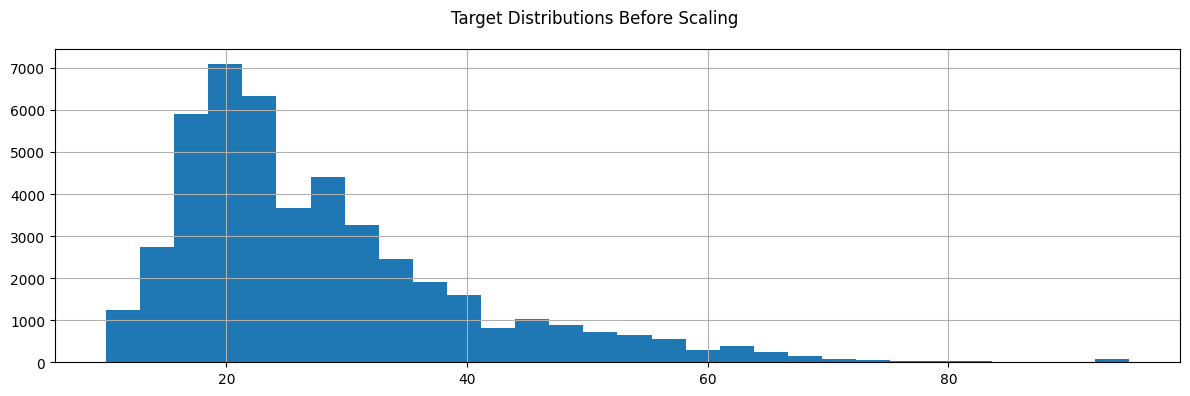

In [100]:
gdf[target_col].hist(bins=30, figsize=(12, 4))
plt.suptitle("Target Distributions Before Scaling")
plt.tight_layout()
plt.show()

# Baseline Models

In [101]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.0, num_layers=2, activation='relu', heads=None):
        super().__init__()
        self.dropout = dropout
        self.activation = getattr(F, activation)

        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.activation(x)
        return x


In [102]:
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.0, num_layers=2, activation='relu', heads=1):
        super().__init__()
        self.dropout = dropout
        self.activation = getattr(F, activation)
        self.heads = heads

        self.convs = nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, concat=False))

        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels, hidden_channels, heads=heads, concat=False))

        self.convs.append(GATConv(hidden_channels, out_channels, heads=heads, concat=False))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.activation(x)
        return x

# Execution Pipeline (Run all blocks below once for GCN and once for GAT)

In [103]:
# Step 1. Set configuration
param_grid = {
    'hidden_channels': [128],
    'num_layers': [2, 3, 4, 5],
    'lr_range': [0.01],
    'dropout_range': (0.0, 0.4),
    'dropout_step': 0.1,
    'activation_functions': ['relu', 'elu'],
    'heads': [1, 2, 4],  # Only used for GAT
    'epochs': 20
}

#model_name = "GCN"
#model_class = GCN

model_name = "GAT"
model_class = GAT

outlier_indices = None
#outlier_indices = [139, 259, 345, 455, 457, 1183, 1667, 2326, 2945, 3058, 3370, 3745, 3964, 4000, 4097, 4222, 5010, 6815, 6931, 7527, 7994, 8396, 8554, 8964, 9125, 9264, 9407, 9533, 9876, 10170, 10230, 10398, 10624, 10834, 11447, 11694, 11699, 11923, 12722, 13329, 14537, 15408, 16173, 16365, 17124, 17150, 17875, 18592, 19014, 19184, 19187, 19218, 19287, 19310, 19726, 19745, 19768, 19839, 19990, 20501, 20606, 21052, 21166, 21731, 21933, 22219, 22741, 22934, 23614, 23630, 23843, 24068, 24489, 24681, 25423, 26253, 26541, 27147, 27797, 28099, 28379, 29084, 29150, 29246, 29748, 29932, 30241, 30593, 30939, 31048, 31122, 31959, 32220, 32235, 32346, 32552, 32714, 33258, 34924, 35098, 35664, 36354, 37517, 38242, 38315, 38484, 38642, 39177, 39229, 39759, 40269, 40733, 40783, 40821, 40970, 41153, 41161, 41757, 44206, 44619, 45059, 45101, 45499, 45609, 46217, 46416, 46870, 47005, 47172, 47508, 47583, 47617, 47749, 47993, 48440, 48566]
#coarse_indices = None #get_coarse_node_indices(G, baseline_graph)

In [104]:
# Step 2. Create PyG data object from graph + gdf
data, G = setup_data_object(gdf, feature_cols, target_col, G)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

Data(x=[48595, 97], edge_index=[2, 116996], y=[48595, 1])
✅ Node features shape: torch.Size([48595, 97])
✅ Edge index shape: torch.Size([2, 116996])
✅ Target shape: torch.Size([48595, 1])


In [105]:
# Step 3: Hyperparameter Tuning

# Generate the mask
optuna_mask = get_node_mask(data, exclude_indices=outlier_indices)

# Use in tuning
best_config = run_optuna_tuning(
    model_class=model_class,
    model_name=model_name,
    data=data,
    feature_cols=feature_cols,
    param_grid=param_grid,
    used_mask=optuna_mask
)

🧩 Node Mask Summary:
✔️ Total nodes: 48595
✔️ Labeled nodes: 46664 (96.0%)
✅ Nodes used after exclusion: 46664 (96.0%)
🚀 Starting Optuna tuning (100 trials, 3-fold CV)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-24 21:05:38,149] Trial 0 finished with value: 119.09507333333333 and parameters: {'hidden_channels': 128, 'num_layers': 3, 'lr': 0.01, 'dropout': 0.30000000000000004, 'activation': 'relu', 'heads': 4}. Best is trial 0 with value: 119.09507333333333.
[I 2025-06-24 21:05:39,157] Trial 1 finished with value: 84.94738666666666 and parameters: {'hidden_channels': 128, 'num_layers': 5, 'lr': 0.01, 'dropout': 0.1, 'activation': 'elu', 'heads': 1}. Best is trial 1 with value: 84.94738666666666.
[I 2025-06-24 21:05:39,932] Trial 2 finished with value: 104.65353 and parameters: {'hidden_channels': 128, 'num_layers': 4, 'lr': 0.01, 'dropout': 0.0, 'activation': 'relu', 'heads': 1}. Best is trial 1 with value: 84.94738666666666.
[I 2025-06-24 21:05:40,690] Trial 3 finished with value: 382.11885666666666 and parameters: {'hidden_channels': 128, 'num_layers': 2, 'lr': 0.01, 'dropout': 0.30000000000000004, 'activation': 'elu', 'heads': 4}. Best is trial 1 with value: 84.94738666666666.
[I 

In [106]:
# Step 4: Internal validation after Optuna tuning
internal_validation_mask = get_node_mask(data, exclude_indices=coarse_indices)

internal_metrics = run_internal_cv(
    model_class=model_class,
    model_name=model_name,
    data=data,
    feature_cols=feature_cols,
    config=best_config,
    internal_validation_mask=internal_validation_mask,
    outlier_indices=outlier_indices,
    n_folds=10,
    max_epochs=2500,
    early_stopping_patience=50,
    verbose=True
)

🧩 Node Mask Summary:
✔️ Total nodes: 48595
✔️ Labeled nodes: 46664 (96.0%)
✅ Nodes used after exclusion: 46664 (96.0%)
📊 Fold 1/10 - MSE: 37.0218, R²: 0.754, Epochs: 1575
📊 Fold 2/10 - MSE: 36.9337, R²: 0.775, Epochs: 1952
📊 Fold 3/10 - MSE: 39.0090, R²: 0.752, Epochs: 1724
📊 Fold 4/10 - MSE: 35.8567, R²: 0.781, Epochs: 2130
📊 Fold 5/10 - MSE: 35.2194, R²: 0.772, Epochs: 1834
📊 Fold 6/10 - MSE: 41.5295, R²: 0.731, Epochs: 2122
📊 Fold 7/10 - MSE: 37.5226, R²: 0.753, Epochs: 2291
📊 Fold 8/10 - MSE: 40.1812, R²: 0.732, Epochs: 849
📊 Fold 9/10 - MSE: 38.3348, R²: 0.758, Epochs: 2310
📊 Fold 10/10 - MSE: 38.3641, R²: 0.753, Epochs: 1906

📈 Cross-Validation Summary:
  RMSE   → Mean: 6.163, Std: 0.147
  MAE    → Mean: 3.947, Std: 0.111
  R²     → Mean: 0.756, Std: 0.016
  Epochs → Mean: 1869.3, Std: 407.7


In [107]:
#outlier_indices = [139, 259, 345, 455, 457, 1183, 1667, 2326, 2945, 3058, 3370, 3745, 3964, 4000, 4097, 4222, 5010, 6815, 6931, 7527, 7994, 8396, 8554, 8964, 9125, 9264, 9407, 9533, 9876, 10170, 10230, 10398, 10624, 10834, 11447, 11694, 11699, 11923, 12722, 13329, 14537, 15408, 16173, 16365, 17124, 17150, 17875, 18592, 19014, 19184, 19187, 19218, 19287, 19310, 19726, 19745, 19768, 19839, 19990, 20501, 20606, 21052, 21166, 21731, 21933, 22219, 22741, 22934, 23614, 23630, 23843, 24068, 24489, 24681, 25423, 26253, 26541, 27147, 27797, 28099, 28379, 29084, 29150, 29246, 29748, 29932, 30241, 30593, 30939, 31048, 31122, 31959, 32220, 32235, 32346, 32552, 32714, 33258, 34924, 35098, 35664, 36354, 37517, 38242, 38315, 38484, 38642, 39177, 39229, 39759, 40269, 40733, 40783, 40821, 40970, 41153, 41161, 41757, 44206, 44619, 45059, 45101, 45499, 45609, 46217, 46416, 46870, 47005, 47172, 47508, 47583, 47617, 47749, 47993, 48440, 48566]
# Step 5: Train model on 100% of labeled data
final_train_mask = get_node_mask(data, exclude_indices=outlier_indices)

final_model = train_final_model(
    model_class=model_class,
    model_name=model_name,
    data=data,
    feature_cols=feature_cols,
    config=best_config,
    final_train_mask=final_train_mask,
    max_epochs=2500,
    early_stopping_patience=50,
    verbose=True
)

🧩 Node Mask Summary:
✔️ Total nodes: 48595
✔️ Labeled nodes: 46664 (96.0%)
✅ Nodes used after exclusion: 46664 (96.0%)


🧠 Training GAT:  66%|██████▌   | 1646/2500 [00:31<00:16, 51.51it/s]

✅ Final model trained for 1647 epochs


In [108]:
# 6. Predict on full dataset using the internal model
gdf = predict_full_dataset(final_model, data, gdf=gdf, model_name=model_name)

# ❗ Remove coarse nodes from both gdf and predictions
if coarse_indices is not None:
    # Drop from gdf
    print(f'Dropped {len(coarse_indices)} coarse nodes')
    gdf = gdf.drop(index=coarse_indices).reset_index(drop=True)

✅ Attached predictions and errors to gdf for model: GAT


In [109]:
# 7. External validation
palmes_gdf_updated, external_metrics = run_external_validation(
    gdf=gdf,
    palmes_gdf=palmes_gdf,
    model_name=model_name,
    search_radius=50
)

In [110]:
# Step 8 – Export final results
export_results(
    gdf=gdf,
    palmes_gdf=palmes_gdf_updated,
    export_model_name=f"gat_outliers_not_removed" + model_name,
    config=best_config,
    internal_metrics=internal_metrics,
    external_metrics=external_metrics,
    output_dir="/content/drive/MyDrive/Universiteit Utrecht/Thesis/outputs/"
)

✅ Results successfully exported to: /content/drive/MyDrive/Universiteit Utrecht/Thesis/outputs/


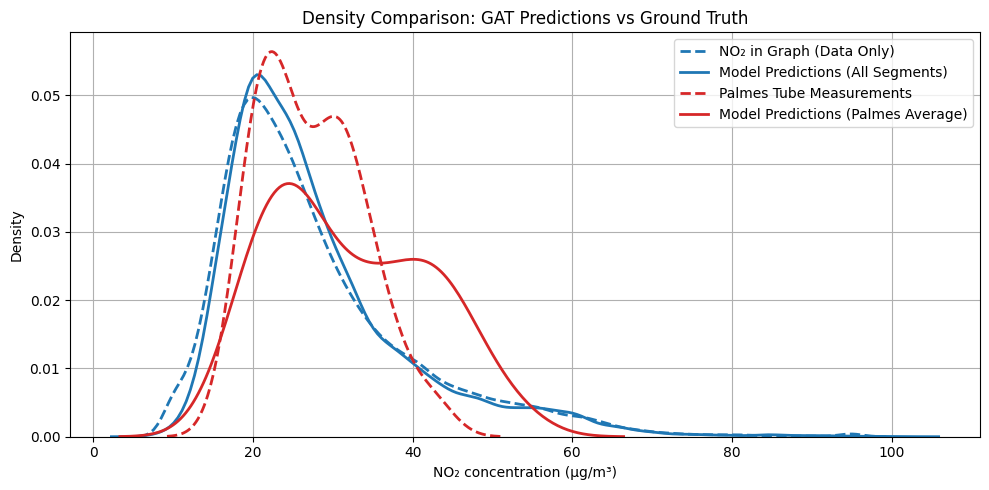

In [111]:
# 9. Plot distributions
plot_density_comparison(
    gdf=gdf,
    palmes_gdf=palmes_gdf_updated,
    model_name=model_name
)

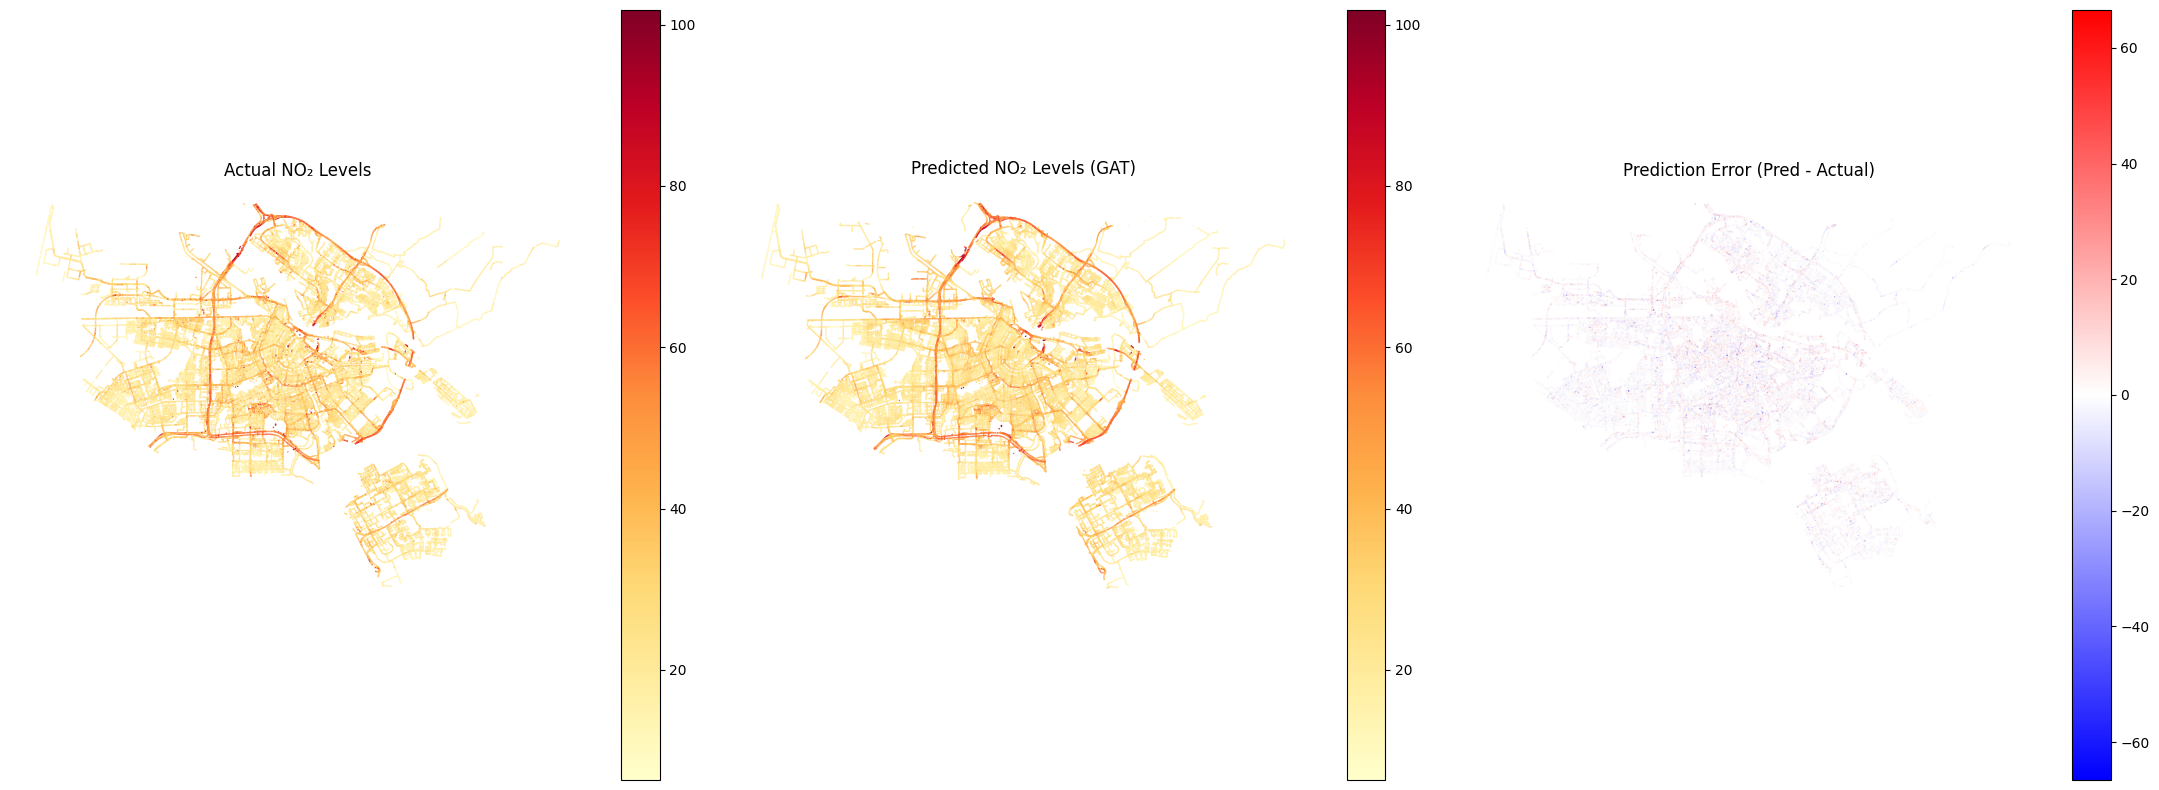

In [112]:
# 10. Visualize predictions on map
plot_segment_predictions(gdf, model_name=model_name)